# MLP Models

## Pre-processing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [133]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head() # Overview of the dataset

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [134]:
ccd.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Shows that there is a huge range of values for inputs that will need normalizing.

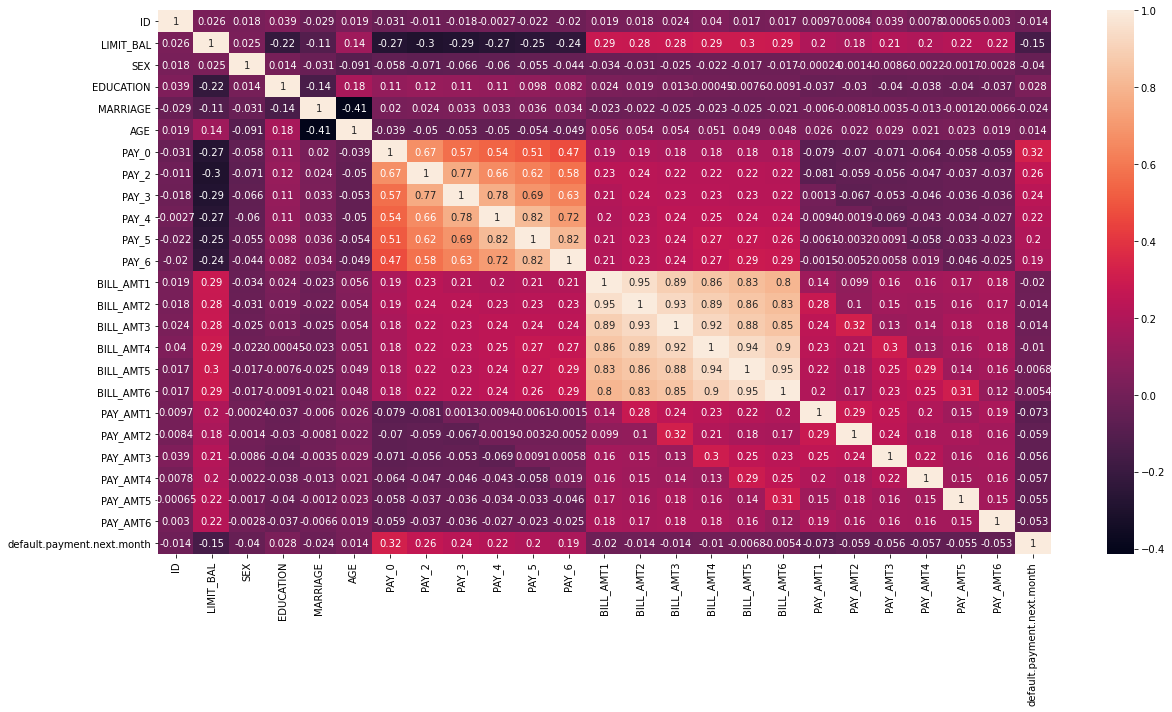

In [135]:
corr = ccd.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True)
plt.show()
corr = np.array(corr)

Shows values which have a positive and negative correlation with the target variable default.payment.next.month

This information can be used for further feature engineering and assist in determining which features to use as inputs, for now we will use all features are inputs.

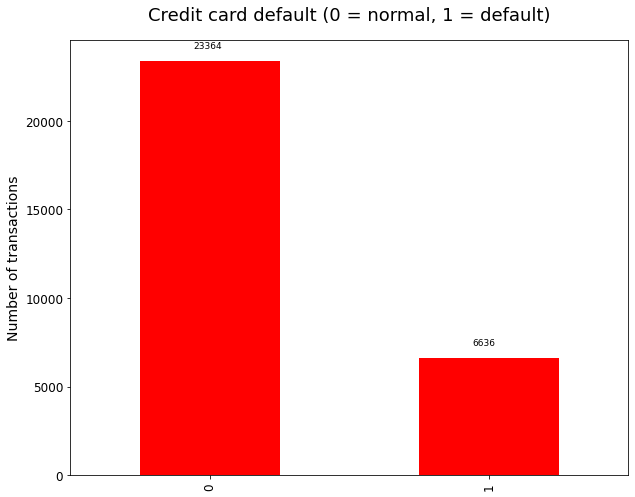

In [136]:
ax = ccd['default.payment.next.month'].value_counts().plot(kind='bar', figsize=(10, 8), fontsize=12, color='red')
ax.set_title('Credit card default (0 = normal, 1 = default)', size=18, pad=20)
ax.set_ylabel('Number of transactions', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=9)

The graph above clearly shows there is a sever imbalance in the target variables which will need to be addressed with some kind of oversampling.

In [137]:
ccd.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Checking there are no null values in the data that will need to be removed or replaces with mean averages. None were found so no further action was taken.

In [138]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


ID column was dropped from the dataset as it was not needed for our modelling.

In [139]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
toscale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[toscale])
scaled = pd.DataFrame(scaled, columns=toscale)

# Replace columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


Now we have seperated the output column from the rest of the data and assigned the input features to the inputs variable, this data was then normalised to ensure all input data is within a 0 - 1 range.

In [140]:
inputs = inputs.values

inputs.shape

(30000, 23)

Above we are just checking that all our input that has the correct shape.

In [141]:
outputs = ccd['default.payment.next.month']

In [142]:
outputs = outputs.values

outputs.shape

(30000,)

In the above cells we are assigning the output target data to the variable outputs and confirming the shape is correct.
Unlike the inputs data we do not need to normalize this data as the values are already between 0 - 1.

In [143]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, stratify = outputs )

In [144]:
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype = torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype = torch.float)

In the two cells above we are splitting the data into train and test, assigning 25% of the data to test and stratifying the outputs so that there is a fair proportion is taken from both 1's and 0's for the random split.

In [145]:
#Partially adapted from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 16)  # input layer
        self.layer_2 = nn.Linear(16, 16)  # hidden layer
        self.layer_out = nn.Linear(16, 1) # output layer
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(16)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

The above is our model which consists of an input layer, a single hidden layer and an output layer. A single hidden layer was chosen as research seems to indicate that for MLP models anything more than 2 layers does not improve performance, for further work with this data it would be worth to test 2 hidden layers to see if that improves performance.
ReLu was also the activation function that was applied to the hidden layer as research indicates that this activation function tends to cover many shortfalls of sigmoid functions. However this is something that we can also experiment with and compare results.
Drop out has also been included, however, as it is showing 0.1 this means that it is actually not being used at the moment, but it is a good tool for controlling overfitting. Ideally we would like to reach a point where the model overfits first before applying tools like this.

In [146]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


As we may be using different devices to run these models, and some devices have Nvidia GPU's the code above ensures that if there is a GPU available and is detected by torch then we can utilise this to run our models more efficiently.

In [147]:
model = binaryClassification()
model.to(device)
print(model)

binaryClassification(
  (layer_1): Linear(in_features=23, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [148]:
# Partially adapted from Lab 5

torch.manual_seed(0)


net = NeuralNetBinaryClassifier(
    binaryClassification,
    max_epochs=50,  
    lr= 0.1,
    callbacks=[EarlyStopping()],         
    optimizer__momentum = 0.8,
    device=device,
)

In the cell above we are utilising Skorch to wrap our torch model and aid us in tuning hyper-parameters for testing.

In [149]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4759       0.8173        0.4577  0.4713
      2        0.4560       0.8171        0.4502  0.4612
      3        0.4503       0.8182        0.4526  0.4613
      4        0.4487       0.8182        0.4445  0.4613
      5        0.4460       0.8153        0.4451  0.4797
      6        0.4440       0.8133        0.4452  0.4713
      7        0.4425       0.8207        0.4377  0.4718
      8        0.4426       0.8182        0.4401  0.4695
      9        0.4417       0.8216        0.4364  0.4714
     10        0.4412       0.8202        0.4368  0.4696
     11        0.4413       0.8191        0.4387  0.4615
     12        0.4407       0.8167        0.4394  0.5039
     13        0.4402       0.8209        0.4371  0.5118
     14        0.4402       0.8213        0.4353  0.4816
     15        0.4390       0.8140        0.4391  0.4692
     16        0.4382       0.8

Upon running our model we can initially see that the accuracy is quite high, at around 82%, however as the data is significantly imbalanced, it is important to take these results with a grain of salt until we can do further testing.

In [150]:
accuracy = cross_val_score(net, X_train, y_train, cv=3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4869       0.8203        0.4479  0.3431
      2        0.4538       0.8060        0.4777  0.3008
      3        0.4481       0.8200        0.4464  0.3108
      4        0.4458       0.8177        0.4432  0.3190
      5        0.4444       0.8207        0.4398  0.3110
      6        0.4438       0.8217        0.4438  0.3110
      7        0.4430       0.8223        0.4363  0.3089
      8        0.4429       0.8130        0.4416  0.3109
      9        0.4423       0.8187        0.4402  0.3028
     10        0.4417       0.8217        0.4409  0.3110
     11        0.4413       0.8123        0.4395  0.3211
     12        0.4400       0.8233        0.4359  0.3412
     13        0.4397       0.8207        0.4372  0.3210
     14        0.4392       0.8130        0.4420  0.3110
     15        0.4391       0.8147        0.4429  0.3210
     16        0.4401       0.8

In [151]:
# Average accuracy

print('Accuracy: {:.2f} %'.format(accuracy.mean()*100))
print('Standard Deviation: {:.2f} %'.format(accuracy.std()*100))

Accuracy: 81.50 %
Standard Deviation: 0.63 %


Running cross validation is a good way to determine an average accuracy for our model and be able to more confidently determine generalisability of our model.

## Evaluation

In [152]:
y_pred = net.predict(X_test)

Now we are evaluating how our model performs against previously unseen data.

In [153]:
accuracy_score(y_test, y_pred)

0.8169333333333333

The accuracy score above shows how effective the model was compared to the actual results.

In [154]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[5528,  313],
       [1060,  599]], dtype=int64)

In [155]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      5841
         1.0       0.66      0.36      0.47      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



<AxesSubplot:>

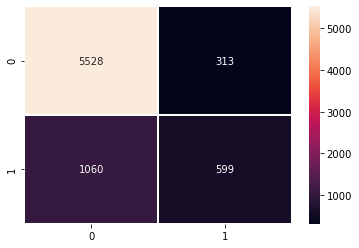

In [156]:
# MLP Confusion Matrix Pre SMOTE
sns.heatmap(cm, annot=True,linewidth = 0.3, fmt='g')

Without SMOTE the accuracy of the model is relatively high at ~82%, however the confusion matrix clearly indicates that the model is not correctly classifying the minority class as well as it should be, this is likely due to the inbalance in the dataset.

## Applying SMOTE

In [157]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)                                                         #only apply smote to the training data for valid result

print(f'''Shape of inputs before SMOTE: {X_train.shape}
Shape of inputs after SMOTE: {X_sm.shape}''')

print(f'''\nShape of outputs before SMOTE: {y_train.shape}
Shape of outputs after SMOTE: {y_sm.shape}''')

print('\nBalance of classes for outputs before SMOTE:')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('\nBalance of classes for outputs after SMOTE:')

#y_sm.value_counts(normalize=True)*100

unique, counts = np.unique(y_sm, return_counts=True)

print(dict(zip(unique, counts)))

Shape of inputs before SMOTE: torch.Size([22500, 23])
Shape of inputs after SMOTE: (35046, 23)

Shape of outputs before SMOTE: torch.Size([22500])
Shape of outputs after SMOTE: (35046,)

Balance of positive and negative classes for outputs before SMOTE:
{0.0: 17523, 1.0: 4977}

Balance of positive and negative classes for outputs after SMOTE:
{0.0: 17523, 1.0: 17523}


In [158]:
X_sm = torch.tensor(X_sm, dtype=torch.float)
y_sm = torch.tensor(y_sm, dtype = torch.float)

Now that the outputs have been upsampled and the data is balanced and converted into a tensor we can run it through our model again and see if the results differ.

In [159]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 16) 
        self.layer_2 = nn.Linear(16, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(16)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [160]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [161]:
model = binaryClassification()
model.to(device)
print(model)

binaryClassification(
  (layer_1): Linear(in_features=23, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [162]:
torch.manual_seed(79)


netsm = NeuralNetBinaryClassifier(
    binaryClassification,
    max_epochs=50,  
    lr= 0.1,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],       
    optimizer__momentum = 0.5,
    #hidden_layer_sizes = (16,16,16)
    device=device,
)

In [163]:
netsm.fit(X_sm, y_sm);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6845       0.6208        0.6601  0.6283
      2        0.6295       0.6708        0.6191  0.6119
      3        0.6051       0.6586        0.6087  0.6221
      4        0.6008       0.6265        0.6516  0.6119
      5        0.5993       0.6805        0.5992  0.5916
      6        0.5955       0.6884        0.5906  0.6038
      7        0.5934       0.6893        0.5897  0.7352
      8        0.5918       0.6402        0.6460  0.6422
      9        0.5920       0.6720        0.6172  0.6140
     10        0.5886       0.6763        0.6033  0.6424
     11        0.5884       0.6843        0.5957  0.6323
Stopping since valid_loss has not improved in the last 5 epochs.


In [164]:
accuracy = cross_val_score(netsm, X_sm, y_sm, cv=3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6914       0.6165        0.6868  0.4820
      2        0.6725       0.6227        0.6486  0.4518
      3        0.6263       0.6095        0.6366  0.4316
      4        0.6056       0.5872        0.6759  0.4113
      5        0.6016       0.6217        0.6530  0.4417
      6        0.6002       0.6844        0.5999  0.4011
      7        0.5954       0.6739        0.6055  0.3911
      8        0.5945       0.6247        0.6341  0.4011
      9        0.5916       0.6687        0.6055  0.4112
     10        0.5897       0.6660        0.6095  0.4094
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6919       0.5097        0.6904  0.3932
      2        0.6862       0.6287        0.6786  0.4114
      3        0.6643  

In [165]:
# Average accuracy

print('Accuracy: {:.2f} %'.format(accuracy.mean()*100))
print('Standard Deviation: {:.2f} %'.format(accuracy.std()*100))

Accuracy: 61.46 %
Standard Deviation: 2.06 %


After using SMOTE to balance the training data it seems that the accuracy of the model has taken a hit, dropping by over 20%.

## Evaluation of SMOTE

In [166]:
y_pred = netsm.predict(X_test)

In [167]:
accuracy_score(y_test, y_pred)

0.4812

When tested against unseen data the model also performs worse after using SMOTE.

In [168]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[2278, 3563],
       [ 328, 1331]], dtype=int64)

In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.39      0.54      5841
         1.0       0.27      0.80      0.41      1659

    accuracy                           0.48      7500
   macro avg       0.57      0.60      0.47      7500
weighted avg       0.74      0.48      0.51      7500



<AxesSubplot:>

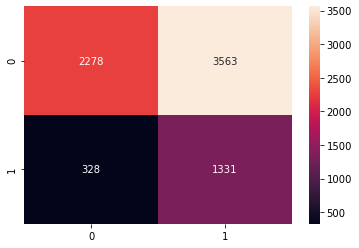

In [170]:
sns.heatmap(cm, annot=True, fmt='g')

Although the accuracy of the model in general hes reduced substantially after applying SMOTE, the model is now detecting much more of the default minority class correctly, with a recall rate of 80%.

Therefore we can say that upsampling the training data has worked in helping the model correctly classify the minority class.

## Gridsearch - Hidden Layer [16]

Now that we know that SMOTE has worked we can run a grid search to find the optimal hyper-parameters to improve the accuracy and recall of the model for both the target classes.

First we start with a hidden layer with 16 neurons as before but this time with a variety of Learning rates and momentum.

For all our grid searches we are utilising a 3 fold cross validation method to save on computation time, ideally we would be using 10 fold for more accurate and reliable results.

In [171]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 16) 
        self.layer_2 = nn.Linear(16, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(16)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [172]:
torch.manual_seed(79)


netsm = NeuralNetBinaryClassifier(
    binaryClassification,
    max_epochs=200,  
    lr= 0.1,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],       
    optimizer__momentum = 0.5,
    device=device,
)

In [173]:
#netsm.get_params().keys()

In [174]:
from sklearn.model_selection import GridSearchCV


params = {
    'lr': [0.005, 0.01, 0.02],
    'max_epochs': [50],
    'optimizer__momentum' : [0.5, 0.6, 0.7]
    
}

stratkfold = StratifiedKFold(n_splits=3)

gs = GridSearchCV(netsm, params, refit=True, cv=stratkfold, scoring='accuracy')   #refit=False

gs.fit(X_sm, y_sm)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6657       0.6647        0.6191  0.5327
      2        0.6094       0.6694        0.6147  0.4813
      3        0.6021       0.6841        0.6007  0.4836
      4        0.5974       0.6829        0.5991  0.4813
      5        0.5930       0.6908        0.5979  0.4833
      6        0.5929       0.6852        0.5980  0.4915
      7        0.5913       0.6861        0.5955  0.4833
      8        0.5886       0.6878        0.5934  0.4813
      9        0.5894       0.6895        0.5927  0.5016
     10        0.5879       0.6837        0.5926  0.4813
     11        0.5875       0.5814        0.7486  0.4915
     12        0.5916       0.6794        0.5936  0.5019
     13        0.5865       0.6835        0.5919  0.5018
     14        0.5837       0.6861        0.5888  0.4915
     15        0.5841       0.6863        0.5870  0.4915
     16        0.5809       0.6

In [175]:
#gs.cv_results_
print(gs.best_score_, gs.best_params_)

0.6980539861895795 {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.5}


In [176]:
# Best parameter set
print('Best parameters found with hidden layers [16]:\n','Accuracy: %0.3f'%gs.best_score_ ,gs.best_params_)

# All results
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found with hidden layers [16,16,16]:
 Accuracy: 0.698 {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.698 (+/-0.015) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.697 (+/-0.008) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.698 (+/-0.006) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.695 (+/-0.007) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.683 (+/-0.041) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.639 (+/-0.146) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.680 (+/-0.047) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.698 (+/-0.010) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.677 (+/-0.053) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.7}


In [177]:
gs_all16=pd.concat([pd.DataFrame(gs.cv_results_['params']),pd.DataFrame(gs.cv_results_['mean_test_score'], columns=['Accuracy'])],axis=1)

print('Hidden Layers [16]')
gs_all16

Hidden Layers [16,16,16]


,lr,max_epochs,optimizer__momentum,Accuracy
0,0.005,50,0.5,0.698054
1,0.005,50,0.6,0.697084
2,0.005,50,0.7,0.697797
3,0.010,50,0.5,0.694630
4,0.010,50,0.6,0.682988
5,0.010,50,0.7,0.638703
6,0.020,50,0.5,0.679735
7,0.020,50,0.6,0.697712
8,0.020,50,0.7,0.676682


The grid search has found that the best combination of hyper parameters for this 16 neuron hidden layer is using a learning rate of 0.005 and a momentum of 0.5 giving a accuracy of 0.698.
However, again when dealing with imbalanced data it is important to look at how accuratly the model has classified each target class.

In [178]:
y_true, y_pred = y_test , gs.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83      5841
         1.0       0.45      0.59      0.51      1659

    accuracy                           0.75      7500
   macro avg       0.66      0.69      0.67      7500
weighted avg       0.78      0.75      0.76      7500



In [179]:
accuracy_score(y_true, y_pred)

0.7481333333333333

In [180]:
cm = confusion_matrix(y_true, y_pred)

cm

array([[4632, 1209],
       [ 680,  979]], dtype=int64)

<AxesSubplot:>

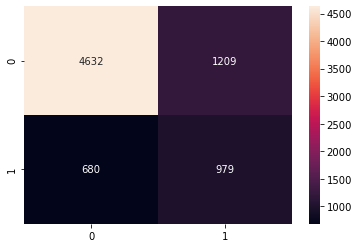

In [181]:
sns.heatmap(cm, annot=True, fmt='g')

Although the best model for a hidden layer with 16 neurons does more accurately classify the majority class it has dropped in recall of the minority class.

## Gridsearch - Hidden Layer [26]

Now we are doing another grid search with the same hyper parameters as last time but this time with a hidden layers with 26 neurons.

In [182]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 26) 
        self.layer_2 = nn.Linear(26, 26)
        self.layer_out = nn.Linear(26, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         
        self.batchnorm1 = nn.BatchNorm1d(26)
        self.batchnorm2 = nn.BatchNorm1d(26)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [183]:
torch.manual_seed(89)


netsm2 = NeuralNetBinaryClassifier(
    binaryClassification,
    max_epochs=200,  
    lr= 0.1,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],       
    optimizer__momentum = 0.5,
    device=device,
)

In [184]:
from sklearn.model_selection import GridSearchCV


params = {
    'lr': [0.005, 0.01, 0.02],
    'max_epochs': [50],
    'optimizer__momentum' : [0.5, 0.6, 0.7]
    
}

stratkfold = StratifiedKFold(n_splits=3)

gs = GridSearchCV(netsm2, params, refit=True, cv=stratkfold, scoring='accuracy')   #refit=False

gs.fit(X_sm, y_sm)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6480       0.6666        0.6156  0.5319
      2        0.6058       0.5542        0.7473  0.5378
      3        0.5955       0.6758        0.5993  0.5308
      4        0.5905       0.6790        0.6036  0.5168
      5        0.5943       0.6822        0.5980  0.5144
      6        0.5866       0.6811        0.5931  0.5115
      7        0.5858       0.6886        0.5900  0.5115
      8        0.5824       0.6454        0.6113  0.5114
      9        0.5810       0.6790        0.5893  0.5116
     10        0.5775       0.6762        0.5966  0.5114
     11        0.5787       0.6801        0.5924  0.5114
     12        0.5781       0.6854        0.5897  0.5013
     13        0.5760       0.6850        0.6172  0.5114
     14        0.5876       0.6863        0.5869  0.5216
     15        0.5799       0.6856        0.5839  0.5114
     16        0.5779       0.6

In [185]:
# Best parameter set
print('Best parameters found with hidden layers [16]:\n','Accuracy: %0.3f'%gs.best_score_ ,gs.best_params_)

# All results
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found with hidden layers [16,16,16]:
 Accuracy: 0.707 {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.705 (+/-0.007) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.705 (+/-0.006) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.703 (+/-0.011) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.670 (+/-0.081) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.707 (+/-0.005) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.701 (+/-0.017) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.690 (+/-0.040) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.691 (+/-0.028) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.699 (+/-0.009) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.7}


In [186]:
gs_all26=pd.concat([pd.DataFrame(gs.cv_results_['params']),pd.DataFrame(gs.cv_results_['mean_test_score'], columns=['Accuracy'])],axis=1)

print('Hidden Layers [26]')
gs_all26

Hidden Layers [26,26,26]


,lr,max_epochs,optimizer__momentum,Accuracy
0,0.005,50,0.5,0.705330
1,0.005,50,0.6,0.704959
2,0.005,50,0.7,0.702676
3,0.010,50,0.5,0.669606
4,0.010,50,0.6,0.707328
5,0.010,50,0.7,0.700765
6,0.020,50,0.5,0.689608
7,0.020,50,0.6,0.691063
8,0.020,50,0.7,0.698967


In [187]:
y_true, y_pred = y_test , gs.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.88      0.64      0.74      5841
         1.0       0.35      0.69      0.47      1659

    accuracy                           0.65      7500
   macro avg       0.62      0.67      0.61      7500
weighted avg       0.76      0.65      0.68      7500



In [188]:
accuracy_score(y_true, y_pred)

0.6528

In [189]:
cm = confusion_matrix(y_true, y_pred)

cm

array([[3746, 2095],
       [ 509, 1150]], dtype=int64)

<AxesSubplot:>

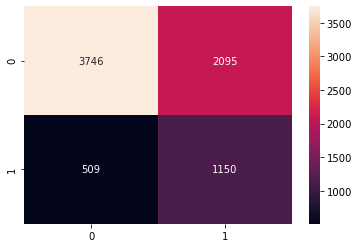

In [190]:
sns.heatmap(cm, annot=True, fmt='g')

This grid search shows a more even balance in recall of the target variables compared with the last models.

## Gridsearch - Hidden Layer [36]

This is now the final grid search for our MLP model, using the same hyper parameters as the last two times but this time looking at a hidden layer with 36 neurons.

In [191]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 36) 
        self.layer_2 = nn.Linear(36, 36)
        self.layer_out = nn.Linear(36, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         
        self.batchnorm1 = nn.BatchNorm1d(36)
        self.batchnorm2 = nn.BatchNorm1d(36)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [192]:
torch.manual_seed(99)


netsm3 = NeuralNetBinaryClassifier(
    binaryClassification,
    max_epochs=50, 
    lr= 0.1,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],       
    optimizer__momentum = 0.5,
    device=device,
)

In [193]:
from sklearn.model_selection import GridSearchCV


params = {
    'lr': [0.005, 0.01, 0.02],
    'max_epochs': [50],
    'optimizer__momentum' : [0.5, 0.6, 0.7]
    
}

stratkfold = StratifiedKFold(n_splits=3)

gs = GridSearchCV(netsm3, params, refit=True, cv=stratkfold, scoring='accuracy')   #refit=False

gs.fit(X_sm, y_sm)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6376       0.6752        0.6035  0.5769
      2        0.5957       0.6854        0.6009  0.5417
      3        0.5876       0.6835        0.5910  0.5497
      4        0.5846       0.6859        0.5880  0.5417
      5        0.5804       0.6831        0.5894  0.5416
      6        0.5813       0.6903        0.5861  0.5335
      7        0.5769       0.5446        1.0927  0.5436
      8        0.5871       0.6867        0.5866  0.5398
      9        0.5773       0.6901        0.5856  0.5335
     10        0.5752       0.6861        0.5862  0.6325
     11        0.5735       0.6871        0.5829  0.5497
     12        0.5737       0.6848        0.5889  0.5315
     13        0.5710       0.6899        0.5835  0.5416
     14        0.5700       0.6730        0.5906  0.5621
     15        0.5690       0.6874        0.5892  0.5922
     16        0.5692       0.6

This model performed quite similarly to the previous model with 26 neurons, however as you can see, early stopping has kicked in much earlier in the number of epochs.

In [194]:
# Best parameters
print('Best parameters found with hidden layers [36]:\n','Accuracy: %0.3f'%gs.best_score_ ,gs.best_params_)

# All results
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found with hidden layers [36,36,36]:
 Accuracy: 0.704 {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.696 (+/-0.020) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.689 (+/-0.028) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.699 (+/-0.003) for {'lr': 0.005, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.686 (+/-0.030) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.699 (+/-0.003) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.701 (+/-0.014) for {'lr': 0.01, 'max_epochs': 50, 'optimizer__momentum': 0.7}
0.704 (+/-0.005) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.5}
0.611 (+/-0.158) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.6}
0.690 (+/-0.029) for {'lr': 0.02, 'max_epochs': 50, 'optimizer__momentum': 0.7}


In [195]:
gs_all36=pd.concat([pd.DataFrame(gs.cv_results_['params']),pd.DataFrame(gs.cv_results_['mean_test_score'], columns=['Accuracy'])],axis=1)

print('Hidden Layers [36]')
gs_all36

Hidden Layers [36,36,36]


,lr,max_epochs,optimizer__momentum,Accuracy
0,0.005,50,0.5,0.696142
1,0.005,50,0.6,0.689237
2,0.005,50,0.7,0.699024
3,0.010,50,0.5,0.686098
4,0.010,50,0.6,0.698853
5,0.010,50,0.7,0.701278
6,0.020,50,0.5,0.704075
7,0.020,50,0.6,0.611054
8,0.020,50,0.7,0.689893


In [196]:
y_true, y_pred = y_test , gs.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      5841
         1.0       0.42      0.60      0.50      1659

    accuracy                           0.73      7500
   macro avg       0.65      0.68      0.66      7500
weighted avg       0.77      0.73      0.75      7500



In [197]:
accuracy_score(y_true, y_pred)

0.7305333333333334

In [198]:
cm = confusion_matrix(y_true, y_pred)

cm

array([[4481, 1360],
       [ 661,  998]], dtype=int64)

<AxesSubplot:>

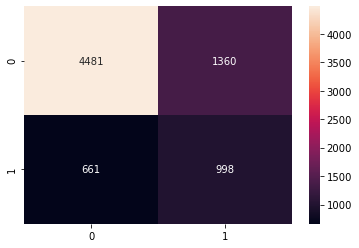

In [199]:
sns.heatmap(cm, annot=True, fmt='g')

The best model with 36 neurons has a similar result to the model with 26 neurons, however, the model with 26 neurons has correctly classified more of both classes.

## Evaluation

In [200]:
print(gs_all16,'\n',gs_all26,'\n',gs_all36)



print('\nBest model with hidden layers [16,16,16]: %0.3f'%gs_all16['Accuracy'].max())
print('\nBest model with hidden layers [26,26,26]: %0.3f'%gs_all26['Accuracy'].max())
print('\nBest model with hidden layers [36,36,36]: %0.3f'%gs_all36['Accuracy'].max())

      lr  max_epochs  optimizer__momentum  Accuracy
0  0.005          50                  0.5  0.698054
1  0.005          50                  0.6  0.697084
2  0.005          50                  0.7  0.697797
3  0.010          50                  0.5  0.694630
4  0.010          50                  0.6  0.682988
5  0.010          50                  0.7  0.638703
6  0.020          50                  0.5  0.679735
7  0.020          50                  0.6  0.697712
8  0.020          50                  0.7  0.676682 
       lr  max_epochs  optimizer__momentum  Accuracy
0  0.005          50                  0.5  0.705330
1  0.005          50                  0.6  0.704959
2  0.005          50                  0.7  0.702676
3  0.010          50                  0.5  0.669606
4  0.010          50                  0.6  0.707328
5  0.010          50                  0.7  0.700765
6  0.020          50                  0.5  0.689608
7  0.020          50                  0.6  0.691063
8  0.020  

## MLP best model

Below we are putting in the best MLP model again, which is the one with 26 neurons, a learning rate of 0.01 and momentum of 0.6.

In [201]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 26) 
        self.layer_2 = nn.Linear(26, 26)
        self.layer_out = nn.Linear(26, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         # 0.1 = no dropout
        self.batchnorm1 = nn.BatchNorm1d(26)
        self.batchnorm2 = nn.BatchNorm1d(26)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [202]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [203]:
model = binaryClassification()
model.to(device)
print(model)

binaryClassification(
  (layer_1): Linear(in_features=23, out_features=26, bias=True)
  (layer_2): Linear(in_features=26, out_features=26, bias=True)
  (layer_out): Linear(in_features=26, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [204]:
torch.manual_seed(0)


net = NeuralNetBinaryClassifier(
    model,
    max_epochs=50, 
    lr= 0.01,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],    
    optimizer__momentum = 0.6,
    device=device,
)

In [205]:
net.fit(X_sm, y_sm);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6157       0.6870        0.5979  0.8655
      2        0.5935       0.6942        0.5875  0.8533
      3        0.5870       0.6964        0.5845  0.7928
      4        0.5837       0.6956        0.5832  0.7825
      5        0.5773       0.7007        0.5804  0.8742
      6        0.5794       0.6994        0.5798  0.8332
      7        0.5771       0.7041        0.5945  0.8515
      8        0.5773       0.7051        0.5741  0.8435
      9        0.5734       0.6973        0.5820  0.8531
     10        0.5713       0.6994        0.5793  0.8415
     11        0.5710       0.7046        0.5735  0.8241
     12        0.5693       0.7023        0.5781  0.8331
     13        0.5705       0.7077        0.5695  0.8433
     14        0.5672       0.7006        0.5799  1.0023
     15        0.5693       0.6917        0.5818  0.8732
     16        0.5684       0.7

## Evaluation

In [206]:
y_pred = net.predict(X_test)

In [207]:
accuracy_score(y_test, y_pred)

0.6544

In [208]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[3708, 2133],
       [ 459, 1200]], dtype=int64)

In [209]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.63      0.74      5841
         1.0       0.36      0.72      0.48      1659

    accuracy                           0.65      7500
   macro avg       0.62      0.68      0.61      7500
weighted avg       0.77      0.65      0.68      7500



<AxesSubplot:>

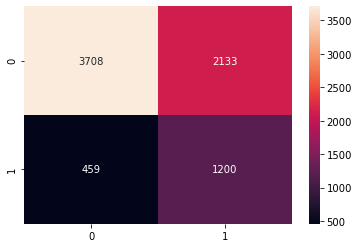

In [210]:
sns.heatmap(cm, annot=True, fmt='g')

Results tend to vary slightly as MLP models always start with random weights, however it is clear that this model performs the best out of all of them.

In [211]:
net

<class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=binaryClassification(
    (layer_1): Linear(in_features=23, out_features=26, bias=True)
    (layer_2): Linear(in_features=26, out_features=26, bias=True)
    (layer_out): Linear(in_features=26, out_features=1, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (batchnorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ),
)

## Save the trained file using pickle

In [83]:
import pickle

# save to local drive
#filename = 'final_mlp_model.pkl'
#with open(filename, 'wb') as file:
#    pickle.dump(net, file)

## Load trained model using pickle

In [212]:
# load the model from disk
filename = 'final_mlp_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_sm, y_sm)
print(result)

0.7070707070707071


Now that the model is saved, it can be used in the separate notebook for further testing.

## SVM Models

Pre-processing done same as before for the MLP model.

In [213]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [214]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [215]:
ccd.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [216]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Scale the data between 0 and 1

In [217]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
to_scale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [218]:
inputs = inputs.values

inputs.shape

(30000, 23)

In [219]:
outputs = ccd['default.payment.next.month']

In [220]:
outputs = outputs.values

outputs.shape

(30000,)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, stratify = outputs )

SMOTE - Balance the data

In [222]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)                                                         #only apply smote to the training data for valid result

print(f'''Shape of inputs before SMOTE: {X_train.shape}
Shape of inputs after SMOTE: {X_sm.shape}''')

print(f'''\nShape of outputs before SMOTE: {y_train.shape}
Shape of outputs after SMOTE: {y_sm.shape}''')

print('\nBalance of positive and negative classes for outputs before SMOTE:')

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('\nBalance of positive and negative classes for outputs after SMOTE:')

#y_sm.value_counts(normalize=True)*100

unique, counts = np.unique(y_sm, return_counts=True)

print(dict(zip(unique, counts)))

Shape of inputs before SMOTE: (22500, 23)
Shape of inputs after SMOTE: (35046, 23)

Shape of outputs before SMOTE: (22500,)
Shape of outputs after SMOTE: (35046,)

Balance of positive and negative classes for outputs before SMOTE:
{0: 17523, 1: 4977}

Balance of positive and negative classes for outputs after SMOTE:
{0: 17523, 1: 17523}


Initially it was decided to try the linear kernel as it is the fastest kernel to compute and it would provide a baseline of performance.

In [95]:
#Create the SVM model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0, cache_size= 2000)#, max_iter=50000, class_weight="balanced")
#Fit the model for the data

classifier.fit(X_sm, y_sm)

#Make the prediction
y_pred = classifier.predict(X_test)

Using cache size of 2000(MB) of RAM will decrease the computation time.

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_sm, y = y_sm, cv = 3)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[4763 1078]
 [ 759  900]]
Accuracy: 68.61 %
Standard Deviation: 0.19 %


<AxesSubplot:>

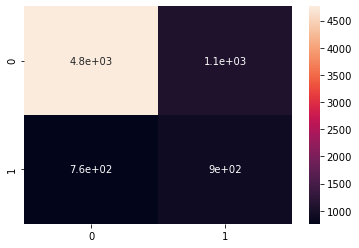

In [97]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')

The model performs well initially however, it is not as good at classifying the minority class as the MLP models.

Now we can run a grid search to identify the best performing model with a variety of parameters including, 3 kernels (RBF, Linear and Polynomial), Gamma (0.0001, 0.001) and degree for polynomial kernel (2,3,4).

In [98]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'C': [1, 10, 100], 'degree': [2, 3, 4]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(cache_size= 2000), tuned_parameters, scoring='%s_macro' % score    #max_iter=50, class_weight="balanced"
    )
    clf.fit(X_sm, y_sm)

    print("Best parameters set found:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores:")
    print()
    means = clf.cv_results_['mean_test_score']  # showing cross val results
    stds = clf.cv_results_['std_test_score']    # showing cross val results
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

# Tuning hyper-parameters for precision

Best parameters set found:

{'C': 100, 'degree': 4, 'kernel': 'poly'}

Grid scores:

0.679 (+/-0.012) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.652 (+/-0.128) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.699 (+/-0.011) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.679 (+/-0.012) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.703 (+/-0.011) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.698 (+/-0.011) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.701 (+/-0.010) for {'C': 1, 'kernel': 'linear'}
0.698 (+/-0.009) for {'C': 10, 'kernel': 'linear'}
0.695 (+/-0.010) for {'C': 100, 'kernel': 'linear'}
0.717 (+/-0.008) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
0.718 (+/-0.008) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
0.723 (+/-0.007) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
0.716 (+/-0.006) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
0.723 (+/-0.008) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
0.728 (+/-0.008) for {'C': 

From the grid search it was clear that the polynomial kernel performed the best so below we are going to run it again and save the model to a pickle so that it can be further evaluated in the other notebook.

In [99]:
#Create the SVM poly model
from sklearn.svm import SVC
bestclassifier = SVC(kernel = 'poly', random_state = 0, C=100, degree=4, probability=True)#, cache_size= 2000)
#Fit the model for the data

bestclassifier.fit(X_sm, y_sm)

#Make prediction
y_pred = classifier.predict(X_test)

In [100]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = bestclassifier, X = X_sm, y = y_sm, cv = 3)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[4763 1078]
 [ 759  900]]
Accuracy: 72.22 %
Standard Deviation: 0.34 %


<AxesSubplot:>

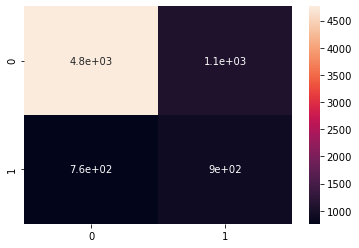

In [101]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [3]:
# save to local drive
filename = 'final_svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(bestclassifier, file)

## Testing Best MLP model against data that has not been oversampled (SMOTE)

In [23]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle


In [24]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Drop ID column as it is not needed.

In [26]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Scale the data between 0 and 1

In [27]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
to_scale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [28]:
inputs = inputs.values

inputs.shape

(30000, 23)

In [29]:
outputs = ccd['default.payment.next.month']

In [30]:
outputs = outputs.values

outputs.shape

(30000,)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42)

print(X_train.shape)
print(y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

(22500, 23)
(22500,)
{0: 17491, 1: 5009}


In [47]:
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype = torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype = torch.float)

In [48]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        
        self.layer_1 = nn.Linear(23, 26) 
        self.layer_2 = nn.Linear(26, 26)
        self.layer_out = nn.Linear(26, 1) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)         # 0.1 = no dropout
        self.batchnorm1 = nn.BatchNorm1d(26)
        self.batchnorm2 = nn.BatchNorm1d(26)        
        

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [50]:
model = binaryClassification()
model.to(device)
print(model)

binaryClassification(
  (layer_1): Linear(in_features=23, out_features=26, bias=True)
  (layer_2): Linear(in_features=26, out_features=26, bias=True)
  (layer_out): Linear(in_features=26, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [51]:
torch.manual_seed(0)


net = NeuralNetBinaryClassifier(
    model,
    max_epochs=50, 
    lr= 0.01,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping()],    
    optimizer__momentum = 0.6,
    device=device,
)

In [52]:
# load the model from disk
filename = 'final_mlp_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, y_train)
print(result)

0.7448888888888889


In [53]:
y_pred = loaded_model.predict(X_test)

In [54]:
accuracy_score(y_test, y_pred)

0.7448

In [55]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[4557, 1316],
       [ 598, 1029]], dtype=int64)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      5873
         1.0       0.44      0.63      0.52      1627

    accuracy                           0.74      7500
   macro avg       0.66      0.70      0.67      7500
weighted avg       0.79      0.74      0.76      7500



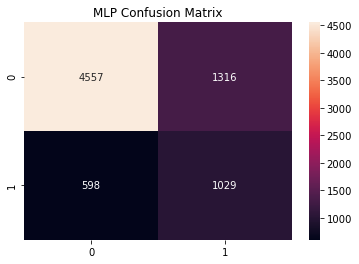

In [57]:
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('MLP Confusion Matrix')
plt.show()

## Testing Best SVM model against data that has not been oversampled (SMOTE)

In [69]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import skorch
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle


In [70]:
ccd = pd.read_csv(r'UCI_Credit_Card.csv')

ccd.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Drop ID column as it is not needed.

In [71]:
ccd = ccd.drop('ID', axis=1)
#ccd = ccd.drop(index=0, axis=2)

ccd.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Scale the data between 0 and 1

In [72]:
from sklearn.preprocessing import MinMaxScaler

inputs = ccd.drop('default.payment.next.month', axis=1)  # Drop the 'target' from the inputs.

# Scale only columns that have values greater than 1
to_scale = [col for col in inputs.columns if inputs[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(inputs[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    inputs[col] = scaled[col]
    
inputs

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.212121,0.0,0.500000,0.333333,0.310345,0.2,0.2,0.2,0.2,0.2,...,0.200746,0.243036,0.111622,0.273259,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.141414,0.0,0.500000,0.666667,0.379310,0.1,0.1,0.1,0.1,0.2,...,0.088267,0.168596,0.085794,0.260979,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.020202,0.0,0.333333,0.666667,0.275862,0.6,0.5,0.4,0.1,0.2,...,0.087859,0.179805,0.101057,0.275854,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.070707,0.0,0.500000,0.333333,0.344828,0.3,0.1,0.2,0.2,0.2,...,0.128239,0.209850,0.092403,0.298591,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [73]:
inputs = inputs.values

inputs.shape

(30000, 23)

In [74]:
outputs = ccd['default.payment.next.month']

In [75]:
outputs = outputs.values

outputs.shape

(30000,)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42)

print(X_train.shape)
print(y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

(22500, 23)
(22500,)
{0: 17491, 1: 5009}


In [78]:
#Create the SVM poly model
from sklearn.svm import SVC
bestclassifier = SVC(kernel = 'poly', random_state = 0, C=100, degree=4, probability=True, cache_size= 2000)
#Fit the model for the data

bestclassifier.fit(X_train, y_train)


SVC(C=100, cache_size=2000, degree=4, kernel='poly', probability=True,
    random_state=0)

In [79]:
y_pred = bestclassifier.predict(X_test)

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = bestclassifier, X = X_train, y = y_train, cv = 3)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[5599  274]
 [1111  516]]
Accuracy: 81.33 %
Standard Deviation: 0.08 %


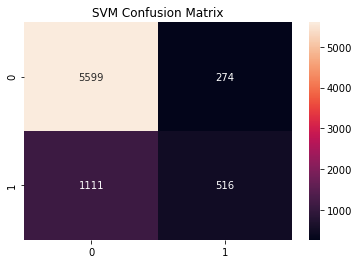

In [81]:
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('SVM Confusion Matrix')
plt.show()

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5873
           1       0.65      0.32      0.43      1627

    accuracy                           0.82      7500
   macro avg       0.74      0.64      0.66      7500
weighted avg       0.80      0.82      0.79      7500

